# Attribution methods

In this notebook I perform attribution methods with the Wts and check for correlation with the sign distributions.

In [1]:
# imports

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

2024-06-10 14:21:33.009462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis_no_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNN2Model_adapted(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model_adapted, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    #@tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        dense1_input = self.flatten(x)
        dense1_out = self.dense1(dense1_input)
        dense2_out = self.dense2(dense1_out)
        dense3_out = self.dense3(dense2_out)
        return dense3_out, dense1_out[0], dense2_out[0]

In [3]:
# get contribution values for neurons
def contribution_scores(test, model):

    # hyperparameters
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializeing contribution scores
    c_score_1 = np.zeros(256)
    c_score_2 = np.zeros(256)

    # get the neurons that don't receive input
    in_dense1 = model.get_weights()[4]
    indexi_unconnected = []
    for i in range(256):
        n_in_dense1 = in_dense1[i]
        if len(list(n_in_dense1[n_in_dense1 != 0.0])) != 0:
            indexi_unconnected.append(i)

    # iterate through testing set and get gradients for each weight
    first_round = True
    for x, t in tqdm(test):

        # get gradients 
        with tf.GradientTape() as tape:
            pred, dense1_out, dense2_out = model(x)
            loss = loss_function(t, pred)
        gradients = tape.gradient(loss, model.trainable_variables)

        # set gradients to zero for all pruned weights
        new_gradients = []
        for gradient_matrix, variables in zip(gradients, model.trainable_variables):
            gradient_matrix = tf.where(variables == 0.0, 0.0, gradient_matrix)
            new_gradients.append(gradient_matrix)
        gradients_dense2 = new_gradients[6]
        gradients_dense3 = new_gradients[8]


        # compute c score for each neuron
        for i in range(256):
            # only include neurons that receive and propagate input
            if i not in indexi_unconnected:
                c_score_1[i] = c_score_1[i] + np.sum(np.abs(gradients_dense2[i]*dense1_out[i]))
            c_score_2[i] = c_score_2[i] + np.sum(np.abs(gradients_dense3[i]*dense2_out[i]))

    # normalize c_scores to values between 0 and 1
    c_score_1 = c_score_1 / np.sum(c_score_1)
    c_score_2 = c_score_2 / np.sum(c_score_2)
    
    return  c_score_1,c_score_2

In [4]:
def try_computing_c_scores():

    # make a model to load the weights into
    train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=1, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset)[0][0])
    weights_wt = model.get_weights()
    #print(weights_wt[0][0][0][0])
    
    # get WT weights
    #model.load_weights(f"1b WTs/old_format/WT_CIFAR_IMP_0") # does not work for thesis env, works for no_gpu, does not work for gpu
    #model.load_weights(f"1b WTs/new_format/WT_CIFAR_IMP_0.weights.h5") # does not work for thesis env, works for no_gpu, does not work for gpu
    model.load_weights(f"1b WTs/h5_format/WT_CIFAR_IMP_0.h5") # does work for thesis env, works for no_gpu, works for gpu     
    weights_wt = model.get_weights()
    #print(weights_wt[0][0][0][0])

    # plot distirbution of contribution values
    for c_score in contribution_scores(test_dataset, model):
        #print(c_score)
        plt.figure()
        plt.hist(c_score)
        plt.show()

#try_computing_c_scores()

In [5]:
# store contribution values for each sign distribution in files
def get_and_store_c_scores(datasets, n_wts):
    train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=2, shuffle_size=512)
    model = CNN2Model_adapted()
    model(list(train_dataset)[0][0])

    for dataset in datasets:
        for i in n_wts:
            train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=1, shuffle_size=512)
            model.load_weights(f"1b WTs/h5_format/WT_{dataset}_IMP_{i}.h5")
            c_scores_1, c_scores_2 = contribution_scores(test_dataset, model)
            np.save(f"5d Contribution values/c_scores_dense1_{dataset}_wt{i}", np.array(c_scores_1))
            np.save(f"5d Contribution values/c_scores_dense2_{dataset}_wt{i}", np.array(c_scores_2))

In [6]:
#get_and_store_c_scores(["CIFAR","CINIC","SVHN"],range(15))
get_and_store_c_scores(["CIFAR"],range(1,15))

100%|██████████| 10000/10000 [24:51<00:00,  6.70it/s]
/tmp/ipykernel_1075144/1594135126.py:46: RuntimeWarning: invalid value encountered in divide
  c_score_1 = c_score_1 / np.sum(c_score_1)
100%|██████████| 10000/10000 [25:16<00:00,  6.59it/s]


0      0.005806
1      0.001856
2      0.002640
3      0.002388
4      0.000346
         ...   
251    0.000046
252    0.011718
253    0.005980
254    0.000468
255    0.000525
Name: c_scores, Length: 256, dtype: float64

0      1.374639e-02
1      3.634752e-04
2      1.982593e-04
3      8.350919e-06
4      1.116876e-05
           ...     
251    2.348064e-03
252    5.391849e-03
253    4.214263e-05
254    9.527877e-09
255    1.178432e-03
Name: c_scores, Length: 256, dtype: float64

prune_rate_in  prune_rate_out  sign_rate_in  sign_rate_out
0         0.913391        0.218750      0.559549       0.480000
1         0.891235        0.226562      0.511785       0.515152
2         0.890381        0.250000      0.522272       0.421875
3         0.916016        0.320312      0.549419       0.574713
4         0.949463        0.355469      0.485507       0.521212
..             ...             ...           ...            ...
237       0.921570        0.242188      0.502724       0.500000
238       0.920105        0.175781      0.561497       0.559242
239       0.930908        0.183594      0.582155       0.526316
240       0.909180        0.281250      0.475134       0.505435
241       0.942261        0.304688      0.443975       0.500000

[242 rows x 4 columns]

prune_rate_in  prune_rate_out  sign_rate_in  sign_rate_out
242       0.203125             0.1      0.514706       0.666667
243       0.273438             0.4      0.505376       0.500000
244       0.281250             0.1      0.456522       0.555556
245       0.304688             0.4      0.567416       0.500000
246       0.339844             0.3      0.568047       0.142857
..             ...             ...           ...            ...
493       0.265625             0.1      0.462766       0.444444
494       0.316406             0.1      0.548571       0.555556
495       0.300781             0.0      0.486034       0.600000
496       0.273438             0.4      0.505376       0.500000
497       0.246094             0.1      0.450777       0.333333

[256 rows x 4 columns]

prune_rate_in  prune_rate_out  sign_rate_in  sign_rate_out  c_scores
0         0.913391        0.218750      0.559549       0.480000  0.005806
1         0.891235        0.226562      0.511785       0.515152  0.001856
2         0.890381        0.250000      0.522272       0.421875  0.002640
3         0.916016        0.320312      0.549419       0.574713  0.002388
4         0.949463        0.355469      0.485507       0.521212  0.000346
..             ...             ...           ...            ...       ...
251            NaN             NaN           NaN            NaN  0.000046
252            NaN             NaN           NaN            NaN  0.011718
253            NaN             NaN           NaN            NaN  0.005980
254            NaN             NaN           NaN            NaN  0.000468
255            NaN             NaN           NaN            NaN  0.000525

[256 rows x 5 columns]

prune_rate_in  prune_rate_out  sign_rate_in  sign_rate_out      c_scores
242       0.203125             0.1      0.514706       0.666667  8.510382e-04
243       0.273438             0.4      0.505376       0.500000  5.755656e-04
244       0.281250             0.1      0.456522       0.555556  4.370024e-03
245       0.304688             0.4      0.567416       0.500000  6.402322e-04
246       0.339844             0.3      0.568047       0.142857  2.306584e-04
..             ...             ...           ...            ...           ...
237            NaN             NaN           NaN            NaN  9.461779e-04
238            NaN             NaN           NaN            NaN  2.938436e-04
239            NaN             NaN           NaN            NaN  9.726615e-08
240            NaN             NaN           NaN            NaN  2.362234e-03
241            NaN             NaN           NaN            NaN  1.578001e-13

[498 rows x 5 columns]

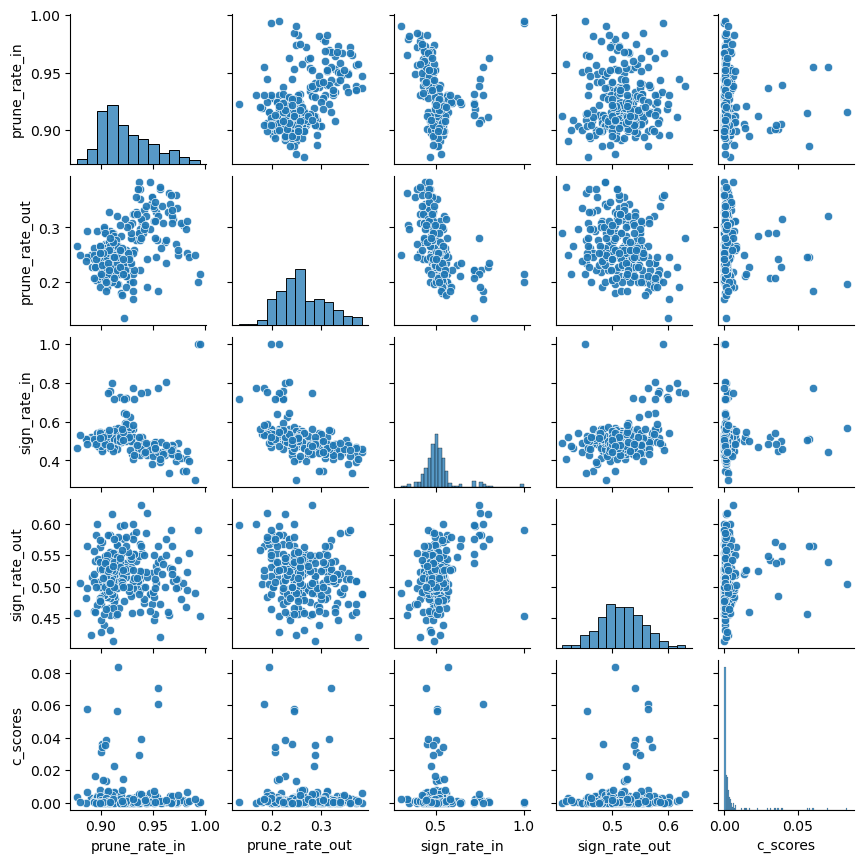

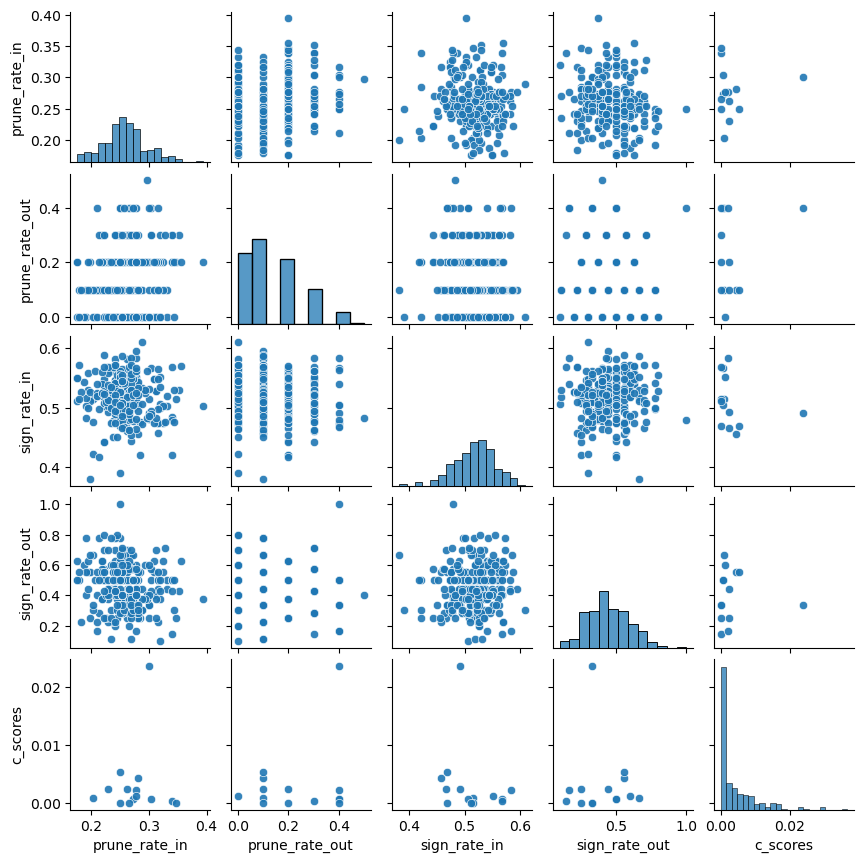

In [7]:
# plot contribution values in scatterplot matrix as 5th dimension

c_scores1 = np.load("5d Contribution values/c_scores_dense1_CIFAR_wt0.npy")
c_scores2 = np.load("5d Contribution values/c_scores_dense2_CIFAR_wt0.npy")
c_scores1 = pd.Series(c_scores1, name="c_scores")
c_scores2 = pd.Series(c_scores2, name="c_scores")
display(c_scores1)
display(c_scores2)

sign_distr = pd.read_csv(f'2b Sign distributions/CIFAR_IMP_0_sign_distr.csv')
sign_distr1 = sign_distr[sign_distr["layer"] == "dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
sign_distr2 = sign_distr[sign_distr["layer"] == "dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
display(sign_distr1)
display(sign_distr2)

sign_distr_combi1 = pd.concat([sign_distr1,c_scores1], axis=1)
sign_distr_combi2 = pd.concat([sign_distr2,c_scores2], axis=1)
display(sign_distr_combi1)
display(sign_distr_combi2)


sns.pairplot(sign_distr_combi1, height=1.75, kind='scatter', plot_kws={'alpha':0.9}) #.savefig(f"3b Plots/{name}_dense1_all_sign_distr.png")
sns.pairplot(sign_distr_combi2, height=1.75, kind='scatter', plot_kws={'alpha':0.9})

In [8]:
# collect statistics for contribution value of each cluster

In [9]:
get_and_store_c_scores(["CINIC"],range(15))

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 20:13:41.460898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:13:41.488864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:13:41.496373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:13:41.513720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:13:41.539990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:13:41.566326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 942/8932 [02:20<19:50,  6.71it/s]2024-06-10 20:16:02.090031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 20:16:02.090053: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 20:36:18.770982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:36:18.771458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:36:18.771488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:36:18.771996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:36:18.772459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:36:18.772917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:19<19:51,  6.71it/s]2024-06-10 20:38:38.678812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 20:38:38.678832: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 20:58:52.554150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:58:52.554593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:58:52.554710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:58:52.554834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:58:52.555531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 20:58:52.556022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:20<20:07,  6.62it/s]2024-06-10 21:01:12.604100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 21:01:12.604128: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 21:21:27.278763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:21:27.279306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:21:27.279344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:21:27.279663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:21:27.280713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:21:27.281190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:20<19:52,  6.70it/s]2024-06-10 21:23:47.375654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 21:23:47.375677: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 21:44:03.804392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:44:03.804942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:44:03.805006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:44:03.805224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:44:03.815537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 21:44:03.816050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:21<19:53,  6.70it/s]2024-06-10 21:46:25.569590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 21:46:25.569612: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 22:06:54.786910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:06:54.787412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:06:54.787529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:06:54.787647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:06:54.788179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:06:54.788678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 942/8932 [02:21<19:53,  6.69it/s]2024-06-10 22:09:16.414867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 22:09:16.414886: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 22:29:43.405901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:29:43.406430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:29:43.406704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:29:43.406759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:29:43.414612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:29:43.415047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:20<19:47,  6.73it/s]2024-06-10 22:32:04.245499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 22:32:04.245518: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 22:52:26.079984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:52:26.080810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:52:26.080914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:52:26.087792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:52:26.088446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 22:52:26.088931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:20<20:05,  6.63it/s]2024-06-10 22:54:46.982165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 22:54:46.982190: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 23:15:06.137615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:15:06.141485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:15:06.142005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:15:06.142224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:15:06.143255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:15:06.143969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:19<19:25,  6.86it/s]2024-06-10 23:17:25.825719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 23:17:25.825740: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-10 23:37:40.011996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:37:40.012409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:37:40.012635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:37:40.012814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-10 23:37:40.013402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 946/8932 [02:21<20:14,  6.57it/s]2024-06-10 23:40:01.643828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-10 23:40:01.643851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'wtpt': ICC profile tag start not a multiple of 4
2024-06-10

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-11 00:00:21.615052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:00:21.615451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:00:21.615698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:00:21.615930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:00:21.616498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:00:21.616966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 942/8932 [02:20<19:48,  6.72it/s]2024-06-11 00:02:42.346400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-11 00:02:42.346422: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-11 00:22:58.420874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:22:58.421459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:22:58.421575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:22:58.421774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:22:58.422344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:22:58.423031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 942/8932 [02:20<20:01,  6.65it/s]2024-06-11 00:25:18.866300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-11 00:25:18.866332: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-11 00:45:34.405158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:45:34.405830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:45:34.405866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:45:34.406815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:45:34.407542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 00:45:34.408510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:20<19:47,  6.73it/s]2024-06-11 00:47:54.583176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-11 00:47:54.583195: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-11 01:08:09.429523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:08:09.429994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:08:09.430037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:08:09.430381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:08:09.430984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:08:09.433371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 941/8932 [02:20<20:10,  6.60it/s]2024-06-11 01:10:30.214863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-11 01:10:30.214894: W tensorflow/core/lib/png/

Found 89326 files belonging to 10 classes.
Using 80394 files for training.
Found 89326 files belonging to 10 classes.
Using 8932 files for validation.


  0%|          | 0/8932 [00:00<?, ?it/s]2024-06-11 01:30:49.468881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:30:49.469315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:30:49.469455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:30:49.469612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:30:49.470249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-06-11 01:30:49.471202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
 11%|█         | 942/8932 [02:20<19:47,  6.73it/s]2024-06-11 01:33:10.213565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2024-06-11 01:33:10.213588: W tensorflow/core/lib/png/

In [10]:
get_and_store_c_scores(["SVHN"],range(15))

100%|██████████| 7325/7325 [18:34<00:00,  6.57it/s]
